In [1]:
!pip install refet
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import bmi_cfe
import bmi_PET
from asce_pet import ETRCalculator

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for refet: filename=refet-0.4.2-py3-none-any.whl size=19276 sha256=25993058e2504c3b88f224208793adceab0c359cfa6c02f5aeb5b3238a5b461b
  Stored in directory: /home/jovyan/.cache/pip/wheels/e3/06/05/814714e678de27f78a8bb862d6879a928fe689a40bc63b6449
Successfully built refet


# 1. Run Normal CFE Simulations

In [2]:
cfe_instance = bmi_cfe.BMI_CFE('./cat-3400554.json')

In [3]:
cfe_instance.initialize()

In [4]:
pet_instance = bmi_PET.BMI_pet_model()
pet_instance.initialize(cfg_file='./config_pet.json', current_time_step=1)
pet_instance.update()
pet_instance.finalize()
pet = pet_instance.get_value('etr')

In [5]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
outputs = cfe_instance.get_output_var_names()
output_lists = {output:[] for output in outputs}

for t, precip in enumerate(df_forcing['APCP_surface']):
    
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)    
    
    cfe_instance.set_value('water_potential_evaporation_flux', pet[t])
   
    cfe_instance.update()
    
    for output in outputs:
    
        output_lists[output].append(cfe_instance.get_value(output))


In [6]:
cfe_instance.finalize(print_mass_balance=True)


GLOBAL MASS BALANCE
  initial volume:   2.1004
    volume input: 593.5995
   volume output: 594.0823
    final volume:   1.6176
        residual: 1.7610e-05

PARTITION MASS BALANCE
    surface runoff: 475.1300
      infiltration:   3.9994
 vol. et from rain: 114.4702
partition residual: 0.0000e+00

GIUH MASS BALANCE
  vol. into giuh: 475.1300
   vol. out giuh: 475.1300
 vol. end giuh q:   0.0000
   giuh residual: 0.0000e+00

SOIL WATER MASS BALANCE
     init soil vol:   0.6166
    vol. into soil:   3.9994
  vol.soil2latflow:   0.3954
   vol. soil to gw:   0.0086
 vol. et from soil:   4.0059
   final vol. soil:   0.2060
  vol. soil resid.: 1.7610e-05

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.3954
  vol. from nash:   0.3946
 final vol. nash:   0.0008
nash casc resid.: 5.6379e-18

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   1.4839
       vol to gw:   0.0086
     vol from gw:   0.0809
final gw.storage:   1.4116
    gw. residual: -3.1086e-1

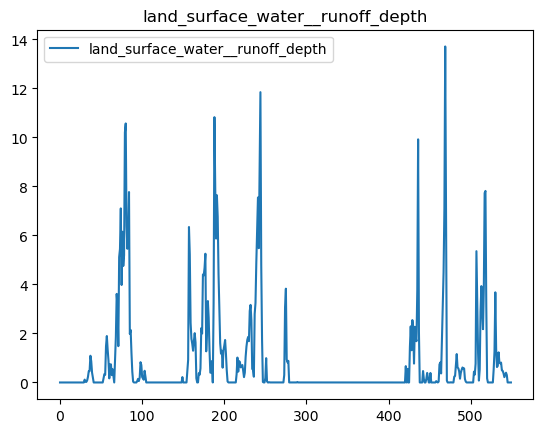

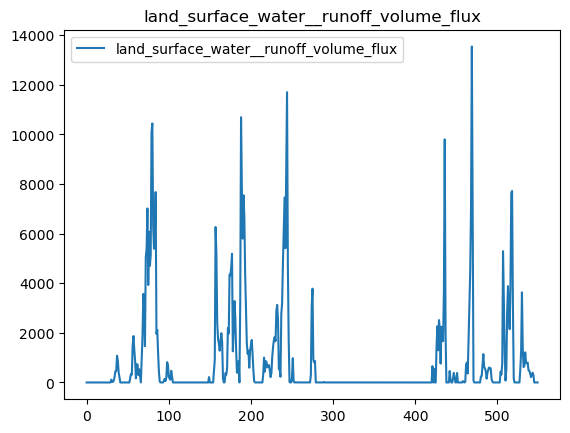

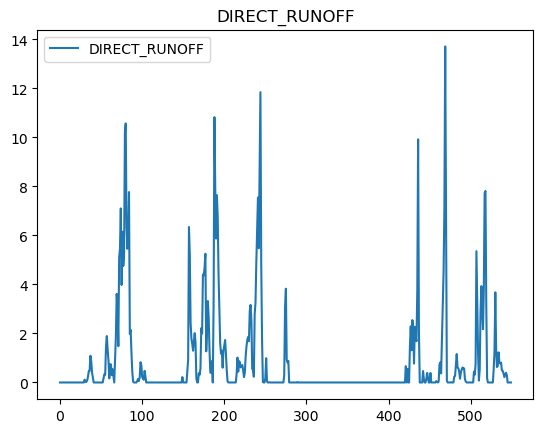

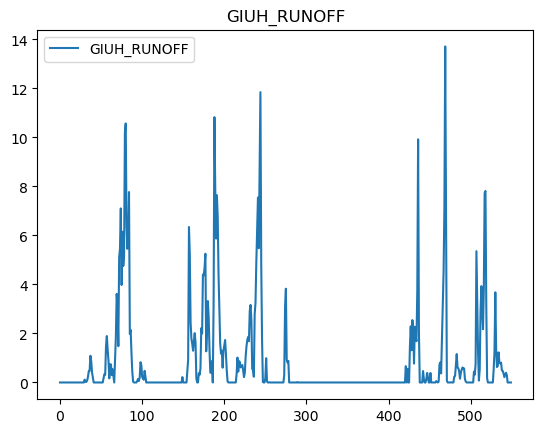

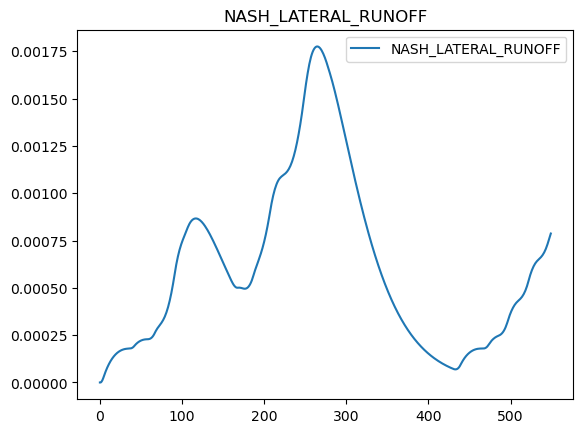

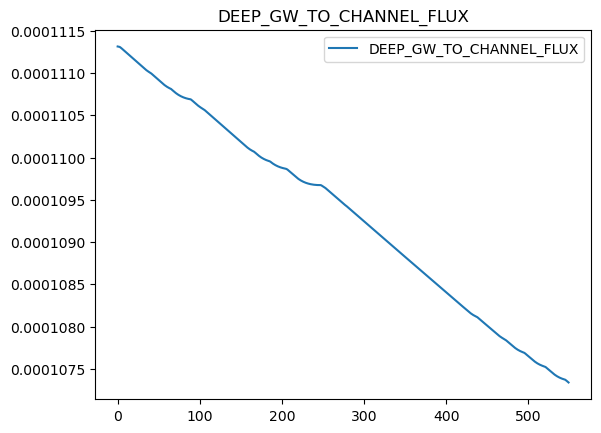

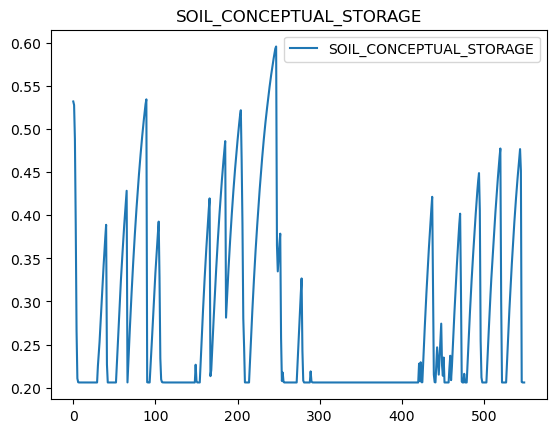

In [7]:
istart_plot = 0
iend_plot = 550
x = list(range(istart_plot, iend_plot))
for output in outputs:
    plt.plot(x, output_lists[output][istart_plot:iend_plot], label=output)
    plt.title(output)
    plt.legend()
    plt.show()
    plt.close()